# Пятая версия.

 - Входные данные, пары: `BTC/USDT, ETH/USDT, BNB/USDT`,
 - Создание целевой функции по окну усреднения, с определением локальных максимумов и минимумов,
 - Устранены двойные сделки за один такт, оставлена сделка с наибольшим профитом,
 - Устранены подряд идущие одинаковые сделки в паре (выбраны сделки с максимумом для продажи и минимумом для покупки)
 - для целевой функции максимумы и минимумы выставлены в верхние и нижние точки тренда
 - созданы признаки при помощи MinMaxScaler или StandardScaler на BASE.
 - добавлен признак DeltaMaxMin - определяющий размах в Scalere,  для различения отмасштабированных Scalerom рядов с разным размахом.
 - создан загрузчик данных (признаки при обучении подаются последовательно),
 - созданы две нейросети на свёртках и макспулинг (отличие в размере ядра и паддинга)
 - при добавлении fee (комиссии сделки) в тесте, кошелёк быстро тает пир большом количестве сделок.
 - создаются две модели отличающиеся по структуре, также две одинаковые проверки на тестовых данных для сравнения моделей. В дальнейшем оставить модель с лучшими показателями, а с худшими изменить, повторно сравнить, так при каждой итерации подбирать лучшую модель,
 - первая функция проверки сохраняет статистику в DataFrame для удобства анализа.
 - для каждой валюты создан словарь, содержащий основные параметры кошелька 
 - создана функция выполнения сделки, с сохранением последней сделки для валюты
 - создана функция проверки соотнишения валют в кошельке, работает плохо, приводит к блокировке торгов
 - Если при продаже выбирать только прибыльные сделки для компенсиции fee, то система приближается к какому то уровню кошелька и перестаёт торговать (вероятно сделки идут по продаже одной валюты, количество валюты уменьшается и системе нечем торговать).


## Импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time
from datetime import datetime

from tqdm import tqdm

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import phik
from phik.report import plot_correlation_matrix
from phik import report

import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torch.optim as optim

pd.set_option("display.max_columns", None)
RANDOM = 1111
PERIOD = 120 # Период усреднения при подготовке признаков (360 = 30 минут с периодом 5 сек)
FEATURES_LENGHT = 224 # 1440 = 2 часа с периодом 5 сек
BATCH_SIZE = 512
EPOCH = 500
FEE = 0.001

# Создание признаков

## Считывание данных из файла

In [2]:
trend = pd.read_csv('binance_features/BTC_ETH_BNB_train_5.csv', sep=';', names=['BTC/USTD','ETH/USTD','BNB/USTD', 'server_time'])
trend['server_time'] = trend['server_time'].apply(lambda x: datetime.utcfromtimestamp(int(str(x)[:10])).strftime('%Y-%m-%d %H:%M:%S'))
trend['server_time'] = pd.to_datetime(trend['server_time'])
trend = trend.set_index('server_time')
trend['numeric_index'] = range(trend.shape[0])

## Получение среза по датам

In [3]:
#trend = trend[(trend.index >= datetime(2022, 7, 17)) & (trend.index < datetime(2022, 7, 18))]
#trend = trend[47000:51000]

## Создание признаков

### 'BTC/BNB', 'BTC/ETH', 'ETH/BNB'

In [4]:
trend['BTC/BNB'] = trend['BTC/USTD']/trend['BNB/USTD']
trend['BTC/ETH'] = trend['BTC/USTD']/trend['ETH/USTD']
trend['ETH/BNB'] = trend['ETH/USTD']/trend['BNB/USTD']

#### delta BASE

In [5]:
trend['BTC/ETH_delta'] = trend['BTC/ETH'] - trend['BTC/ETH'].shift(1)
trend['BTC/BNB_delta'] = trend['BTC/BNB'] - trend['BTC/BNB'].shift(1)
trend['ETH/BNB_delta'] = trend['ETH/BNB'] - trend['ETH/BNB'].shift(1)

### ratio

In [6]:
trend['btc_bnb_ratio'] = trend['BTC/BNB']/trend['BTC/BNB'][0]
trend['btc_eth_ratio'] = trend['BTC/ETH']/trend['BTC/ETH'][0]
trend['eth_bnb_ratio'] = trend['ETH/BNB']/trend['ETH/BNB'][0]

### mean
 Среднее по количеству стобцов PERIOD * 2 + 1

In [7]:
for column in ('btc_bnb_ratio', 'btc_eth_ratio', 'eth_bnb_ratio'):
    # создание столбцов shift
    for period in range(-PERIOD, (PERIOD+1)):
        trend[column + '_' + str(period)] = trend[column].shift(period)
    # получение среднего по столбцам  shift
    trend[column + '_mean'] = trend[[column + '_' + str(x) for x in range(-PERIOD, (PERIOD+1))]].mean(axis=1)
    # удаление столбцов shift
    trend = trend.drop(columns = [column + '_' + str(x) for x in range(-PERIOD, (PERIOD+1))])

C:\Users\denis\AppData\Local\Temp\ipykernel_16276\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_16276\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_16276\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

C:\Users\denis\AppData\Local\Temp\ipykernel_16276\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_16276\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_16276\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

C:\Users\denis\AppData\Local\Temp\ipykernel_16276\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_16276\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_16276\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

#### mean delta

In [8]:
trend['btc_eth_ratio_mean_delta'] = trend['btc_eth_ratio_mean'] - trend['btc_eth_ratio_mean'].shift(1)
trend['btc_bnb_ratio_mean_delta'] = trend['btc_bnb_ratio_mean'] - trend['btc_bnb_ratio_mean'].shift(1)
trend['eth_bnb_ratio_mean_delta'] = trend['eth_bnb_ratio_mean'] - trend['eth_bnb_ratio_mean'].shift(1)

### buy, sell

#### Минимумы и максимумы среднего

In [9]:
for column in ('btc_eth_ratio_mean_delta', 'btc_bnb_ratio_mean_delta', 'eth_bnb_ratio_mean_delta'):
    sign = np.sign(trend[column])
    column = '_'.join(column.split('_')[:-1])
    trend[column + '_min'] = ((sign*2+np.roll(sign,1)) == 1).astype('int')
    trend[column + '_max'] = ((sign*2+np.roll(sign,1)) == -1).astype('int')

#### Выбор локальных минимумов.

In [10]:
%%time
for column in ('btc_eth_ratio_mean_min', 'btc_bnb_ratio_mean_min', 'eth_bnb_ratio_mean_min'):

    list_idx = trend[trend[column] == 1]['numeric_index'].values
    for idx in list_idx:
#         print(idx)
        index_min = trend[trend['numeric_index'] == idx].index
        idx_range = range(idx-PERIOD, idx+PERIOD)
#         print(index_min)
        range_table = trend.query('numeric_index in @idx_range')['_'.join(column.split('_')[:-2])]
        range_table_min = range_table.min()
        index_buy = range_table[range_table == range_table_min].index
#         print(index_buy)
        trend.loc[index_min, column] = 0
        trend.loc[index_buy, column] = 1

CPU times: total: 23.7 s
Wall time: 21.7 s


#### Выбор локальных максимумов.

In [11]:
%%time
for column in ('btc_eth_ratio_mean_max', 'btc_bnb_ratio_mean_max', 'eth_bnb_ratio_mean_max'):

    list_idx = trend[trend[column] == 1]['numeric_index'].values
    for idx in list_idx:
#         print(idx)
        index_max = trend[trend['numeric_index'] == idx].index
        idx_range = range(idx-PERIOD, idx+PERIOD)
#         print(index_max)
        range_table = trend.query('numeric_index in @idx_range')['_'.join(column.split('_')[:-2])]
        range_table_max = range_table.max()
        index_sell = range_table[range_table == range_table_max].index
#         print(index_sell)
        trend.loc[index_max, column] = 0
        trend.loc[index_sell, column] = 1

CPU times: total: 24.1 s
Wall time: 22.5 s


#### Профит каждой сделки

In [12]:
for column in ('btc_bnb', 'btc_eth', 'eth_bnb'):
    trend[column + '_deal'] = trend[column + '_ratio_mean_min'] + trend[column + '_ratio_mean_max']
    trend[column + '_profit'] = abs(trend[trend[column + '_deal'] == 1][column + '_ratio'] - trend[trend[column + '_deal'] == 1][column + '_ratio'].shift(-1))

#### Более одной продажи (двойные сделки)

In [13]:
trend['duble_buy'] = (trend['btc_bnb_deal']+
                      trend['btc_eth_deal']+
                      trend['eth_bnb_deal'])>1

#### Устранение двойных сделок

In [14]:
trend['btc_bnb_profit'] = trend['btc_bnb_deal']*trend['btc_bnb_profit']
trend['btc_eth_profit'] = trend['btc_eth_deal']*trend['btc_eth_profit']
trend['eth_bnb_profit'] = trend['eth_bnb_deal']*trend['eth_bnb_profit']

trend['profit_max'] = trend[trend['duble_buy']][['btc_bnb_profit','btc_eth_profit','eth_bnb_profit']].idxmax(axis=1)

trend.loc[trend['profit_max'] == 'btc_bnb_profit',['btc_eth_ratio_mean_min', 'btc_eth_ratio_mean_max','eth_bnb_ratio_mean_min','eth_bnb_ratio_mean_max']] = 0
trend.loc[trend['profit_max'] == 'btc_eth_profit',['btc_bnb_ratio_mean_min', 'btc_bnb_ratio_mean_max','eth_bnb_ratio_mean_min','eth_bnb_ratio_mean_max']] = 0
trend.loc[trend['profit_max'] == 'eth_bnb_profit',['btc_eth_ratio_mean_min', 'btc_eth_ratio_mean_max','btc_bnb_ratio_mean_min','btc_bnb_ratio_mean_max']] = 0

In [15]:
columns = ['btc_bnb', 'btc_eth', 'eth_bnb']
for column in columns:

    # Подтягиваем покупку и продажу к цене, для удобства отображения на графике и оценки сделок
    trend[column + '_min_price'] = trend[column + '_ratio_mean_min']*trend[column + '_ratio']
    trend[column + '_max_price'] = trend[column + '_ratio_mean_max']*trend[column + '_ratio']    

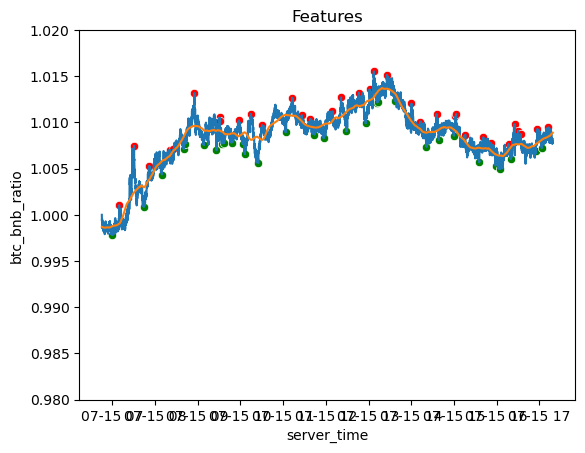

In [16]:
fig, ax = plt.subplots()
# sns.lineplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_ratio', ax=ax)
# sns.lineplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_ratio_mean', ax=ax)
# sns.scatterplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_min_price', ax=ax, color='green')
# sns.scatterplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_max_price', ax=ax, color='red')
sns.lineplot(data=trend[:6000], x='server_time', y ='btc_bnb_ratio', ax=ax)
sns.lineplot(data=trend[:6000], x='server_time', y ='btc_bnb_ratio_mean', ax=ax)
sns.scatterplot(data=trend[:6000], x='server_time', y ='btc_bnb_min_price', ax=ax, color='green')
sns.scatterplot(data=trend[:6000], x='server_time', y ='btc_bnb_max_price', ax=ax, color='red')
plt.title('Features')
plt.ylim([0.98, 1.02])
plt.show()

#### Устранение подряд идущих одинаковых сделок (продажа и покупка должны чередоваться)

In [17]:
columns = ['btc_bnb', 'btc_eth', 'eth_bnb']
for column in columns:


    # выделение локальных максимумов через разницу со сдвигами +- 1, обе разницы должны быть положительными
    max_price = trend[(trend[column + '_max_price'] - trend[column + '_min_price']) !=0][column + '_max_price']
    max_price_true = (max_price-max_price.shift(-1) > 0) & (max_price-max_price.shift(1) > 0)
    trend[column + '_max_price'] = (trend[column + '_max_price']*max_price_true).fillna(0)
    trend[column + '_ratio_mean_max'] = max_price_true
    trend[column + '_ratio_mean_max'] = trend[column + '_ratio_mean_max'].fillna(0).astype('int')


    # выделение локальных минимумов через разницу со сдвигами +- 1, обе разницы должны быть отрицательными.
    # предварительно 0 заменяем на 10, заведомо больше максимумов.
    min_price = trend[(trend[column + '_max_price'] - trend[column + '_min_price']) !=0][column + '_min_price']
    min_price.loc[min_price == 0] =10
    min_price_true = (min_price-min_price.shift(-1) < 0) & (min_price-min_price.shift(1) < 0)
    trend[column + '_min_price'] = (trend[column + '_min_price']*min_price_true).fillna(0)
    trend[column + '_ratio_mean_min'] = min_price_true
    trend[column + '_ratio_mean_min'] = trend[column + '_ratio_mean_min'].fillna(0).astype('int')

del max_price, max_price_true, min_price, min_price_true

C:\Users\denis\AppData\Local\Temp\ipykernel_16276\571222238.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_price.loc[min_price == 0] =10
C:\Users\denis\AppData\Local\Temp\ipykernel_16276\571222238.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_price.loc[min_price == 0] =10
C:\Users\denis\AppData\Local\Temp\ipykernel_16276\571222238.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_price.loc[min_price == 0] =1

#### Перенос целей в максимумы между минимумами, и минимумы между максимами.

In [18]:
columns = ['btc_bnb', 'btc_eth', 'eth_bnb']

for column in columns:
    min_index = trend[trend[column + '_ratio_mean_min'] == 1].index
    trend[column + '_ratio_mean_max'] = 0
    index_previus = trend[:].index[0]
    
    for index in min_index:
        temp = trend.loc[index_previus:index][column + '_ratio']
        max_index = temp[temp == temp.max()].index
        trend[column + '_ratio_mean_max'].loc[max_index] = 1
        index_previus = index
    
    max_index = trend[trend[column + '_ratio_mean_max'] == 1].index
    trend[column + '_ratio_mean_min'] = 0
    index_previus = trend[:].index[0]
    
    for index in max_index:
        temp = trend.loc[index_previus:index][column + '_ratio']
        min_index = temp[temp == temp.min()].index
        trend[column + '_ratio_mean_min'].loc[min_index] = 1
        index_previus = index    

C:\Users\denis\AppData\Local\Temp\ipykernel_16276\1742788990.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trend[column + '_ratio_mean_max'].loc[max_index] = 1
C:\Users\denis\AppData\Local\Temp\ipykernel_16276\1742788990.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trend[column + '_ratio_mean_min'].loc[min_index] = 1


#### График

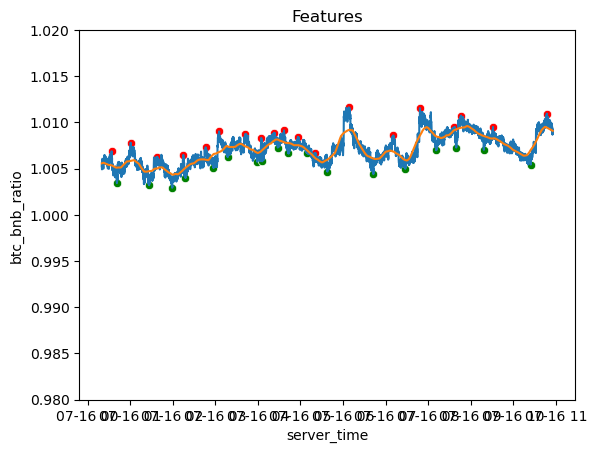

In [19]:
fig, ax = plt.subplots()
# sns.lineplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_ratio', ax=ax)
# sns.lineplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_ratio_mean', ax=ax)
# sns.scatterplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_min_price', ax=ax, color='green')
# sns.scatterplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_max_price', ax=ax, color='red')
sns.lineplot(data=trend[10000:16000], x='server_time', y ='btc_bnb_ratio', ax=ax)
sns.lineplot(data=trend[10000:16000], x='server_time', y ='btc_bnb_ratio_mean', ax=ax)
sns.scatterplot(data=trend[10000:16000], x='server_time', y ='btc_bnb_min_price', ax=ax, color='green')
sns.scatterplot(data=trend[10000:16000], x='server_time', y ='btc_bnb_max_price', ax=ax, color='red')
plt.title('Features')
plt.ylim([0.98, 1.02])
plt.show()

### not_buy

In [20]:
trend['not_buy'] = ((trend['btc_bnb_ratio_mean_min']+
                     trend['btc_bnb_ratio_mean_max']+
                     trend['btc_eth_ratio_mean_min']+
                     trend['btc_eth_ratio_mean_max']+
                     trend['eth_bnb_ratio_mean_min']+
                     trend['eth_bnb_ratio_mean_max']) == 0).astype('int')

### Обрезка датафрейма с верху и низу на PERIOD

In [21]:
trend = trend.iloc[PERIOD+1:-PERIOD-1]

In [22]:
trend.shape

(76523, 40)

### Распределение классов

In [23]:
trend[['btc_bnb_ratio_mean_min',
       'btc_bnb_ratio_mean_max',
       'btc_eth_ratio_mean_min',
       'btc_eth_ratio_mean_max',
       'eth_bnb_ratio_mean_min',
       'eth_bnb_ratio_mean_max',
       'not_buy']].sum()*100/trend.shape[0]

btc_bnb_ratio_mean_min     0.325392
btc_bnb_ratio_mean_max     0.325392
btc_eth_ratio_mean_min     0.241757
btc_eth_ratio_mean_max     0.243064
eth_bnb_ratio_mean_min     0.312324
eth_bnb_ratio_mean_max     0.307097
not_buy                   98.342982
dtype: float64

In [24]:
trend.shape

(76523, 40)

## Создание признаков методом отжига?

## PyTorch

### Выделение признаков

#### Признаковые поля StandardScaler, MinMaxScaler, DeltaMaxMin
StandardScaler (trend - trend.mean) / trend.std

MinMaxScaler  delta / (delta.max - delta.min)

In [25]:
X_temp = trend[['BTC/BNB','BTC/ETH','ETH/BNB']] 
X_temp.shape

(76523, 3)

In [26]:
X_scaled = list()
X_delta_maxmin = list()

#scaler = StandardScaler()
scaler = MinMaxScaler()

for i in tqdm(range(FEATURES_LENGHT, X_temp.shape[0])):
    
    X_trend = X_temp.iloc[i-FEATURES_LENGHT+1:i+1]
    X_delta = X_trend.max()-X_trend.min()
    X_delta_maxmin.append(X_delta)
    X_scaled.append(scaler.fit_transform(X_trend).T)

X_scaled = np.array(X_scaled)
X_delta_maxmin = np.array(X_delta_maxmin)

100%|███████████████████████████████████████████████████████████████████████████| 76299/76299 [02:17<00:00, 556.91it/s]


In [27]:
X_scaled.shape, X_delta_maxmin.shape

((76299, 3, 224), (76299, 3))

In [28]:
np.save('binance_features/nparray_X_scaled', X_scaled, allow_pickle=True, fix_imports=True)
np.save('binance_features/nparray_X_delta_maxmin', X_delta_maxmin, allow_pickle=True, fix_imports=True)

#### Целевая функция

y

- not_buy - 0
- btc_bnb_ratio_mean_min - 1	
- btc_bnb_ratio_mean_max - 2	
- btc_eth_ratio_mean_min - 3
- btc_eth_ratio_mean_max - 4	
- eth_bnb_ratio_mean_min - 5	
- eth_bnb_ratio_mean_max - 6

In [29]:
Y = trend[['btc_bnb_ratio_mean_min','btc_bnb_ratio_mean_max','btc_eth_ratio_mean_min','btc_eth_ratio_mean_max','eth_bnb_ratio_mean_min','eth_bnb_ratio_mean_max','not_buy']]

Y=Y.rename(
    columns={
        'not_buy':'0',
        'btc_bnb_ratio_mean_min':'1',
        'btc_bnb_ratio_mean_max':'2',
        'btc_eth_ratio_mean_min':'3',
        'btc_eth_ratio_mean_max':'4',
        'eth_bnb_ratio_mean_min':'5',
        'eth_bnb_ratio_mean_max':'6'        
    }
)

y = Y.idxmax(axis=1)[FEATURES_LENGHT:]

In [30]:
print(X_scaled.shape, y.shape)

(76299, 3, 224) (76299,)


##### Проверка соответствия признаков разметке.

In [31]:
X_scaled_trend = X_scaled[:,:,-1]

In [32]:
y_trend = (y.astype('int') == 6).astype('int')

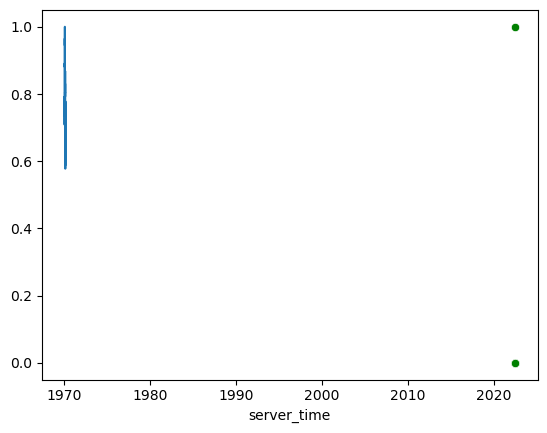

In [33]:
fig, ax = plt.subplots()
sns.lineplot(data=X_scaled_trend[10950:11000,2], ax=ax)
sns.scatterplot(data=y_trend[10950:11000], ax=ax, color='green')

plt.show()

In [34]:
X_scaled.shape, X_delta_maxmin.shape, y.shape

((76299, 3, 224), (76299, 3), (76299,))

In [35]:
X_valid = X_scaled[:4603]
X_scaled = X_scaled[4603:]
X_delta_maxmin_valid = X_delta_maxmin[:4603]
X_delta_maxmin = X_delta_maxmin[4603:]
y_valid = y[:4603]
y = y[4603:]

In [36]:
X_scaled.shape, X_delta_maxmin.shape, y.shape

((71696, 3, 224), (71696, 3), (71696,))

##### Устранение дисбаланса целевой функции

In [37]:
values, counts = np.unique(y, return_counts=True)
print(values, counts)

['0' '1' '2' '3' '4' '5' '6'] [70506   233   233   171   170   201   182]


In [38]:
i, = np.where(y == '1')
X_1 = X_scaled[i]
X_delta_1 = X_delta_maxmin[i]
y_1 = y[i]
i, = np.where(y == '2')
X_2 = X_scaled[i]
X_delta_2 = X_delta_maxmin[i]
y_2 = y[i]
i, = np.where(y == '3')
X_3 = X_scaled[i]
X_delta_3 = X_delta_maxmin[i]
y_3 = y[i]
i, = np.where(y == '4')
X_4 = X_scaled[i]
X_delta_4 = X_delta_maxmin[i]
y_4 = y[i]
i, = np.where(y == '5')
X_5 = X_scaled[i]
X_delta_5 = X_delta_maxmin[i]
y_5 = y[i]
i, = np.where(y == '6')
X_6 = X_scaled[i]
X_delta_6 = X_delta_maxmin[i]
y_6 = y[i]

In [39]:
for i in tqdm(range(200)):
    X_scaled = np.concatenate((X_scaled, X_1, X_2, X_3, X_4, X_5, X_6), axis=0)
    X_delta_maxmin = np.concatenate((X_delta_maxmin, X_delta_1, X_delta_2, X_delta_3, X_delta_4, X_delta_5, X_delta_6), axis=0)
    y = np.concatenate((y, y_1, y_2, y_3, y_4, y_5, y_6), axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:41<00:00,  4.81it/s]


In [40]:
X_scaled.shape

(309696, 3, 224)

In [41]:
values, counts = np.unique(y, return_counts=True)
print(values, counts)

['0' '1' '2' '3' '4' '5' '6'] [70506 46833 46833 34371 34170 40401 36582]


In [42]:
print(X_scaled.shape, X_delta_maxmin.shape, y.shape)

(309696, 3, 224) (309696, 3) (309696,)


In [43]:
print(f'X memory usage {(X_scaled.nbytes/1_000_000_000):.1f} GB')

X memory usage 1.7 GB


#### Перемешивание признаков

In [44]:
for i in range (10):
    X_scaled, X_delta_maxmin, y = shuffle(X_scaled, X_delta_maxmin, y, random_state=RANDOM*i)

### Загрузчики данных Модель 1

In [45]:
X_tensor = torch.tensor(X_scaled.astype('float32'))
X_delta_maxmin_tensor = torch.tensor(X_delta_maxmin.astype('float32'))
y_tensor = torch.tensor(y.astype('int')).type(torch.LongTensor)
X_valid_tensor = torch.tensor(X_valid.astype('float32'))
X_delta_maxmin_valid_tensor = torch.tensor(X_delta_maxmin_valid.astype('float32'))
y_valid_tensor = torch.tensor(y_valid.astype('int')).type(torch.LongTensor)

train = data_utils.TensorDataset(X_tensor, X_delta_maxmin_tensor, y_tensor)
train_loader = data_utils.DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)

In [46]:
X_tensor.shape, X_delta_maxmin_tensor.shape, y_tensor.shape

(torch.Size([309696, 3, 224]), torch.Size([309696, 3]), torch.Size([309696]))

In [47]:
X_valid_tensor = X_valid_tensor.to('cuda')
X_delta_maxmin_valid_tensor = X_delta_maxmin_valid_tensor.to('cuda')
y_valid_tensor = y_valid_tensor.to('cuda')
print(X_valid_tensor.shape, X_delta_maxmin_valid_tensor.shape, y_valid_tensor.shape)

torch.Size([4603, 3, 224]) torch.Size([4603, 3]) torch.Size([4603])


In [48]:
dataiter = iter(train_loader)
images, df, labels = dataiter.next()

### Модель 1

#### Конструктор модели 1

In [49]:
class Net_1(nn.Module):
    def __init__(self):
        super(Net_1,self).__init__()
        self.conv1 = nn.Conv1d(3, 9, 3)
        self.pool = nn.MaxPool1d(3)
        self.conv2 = nn.Conv1d(9, 18, 3)
        self.conv3 = nn.Conv1d(18, 36, 3)
        self.fc1 = nn.Linear(252, 60)
        self.fc2 = nn.Linear(63, 14)
        self.fc3 = nn.Linear(14, 7)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x, x_delta):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = torch.cat((x, x_delta), 1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def inference(self, x, x_delta):
        x = self.forward(x, x_delta)
        x = self.sm(x)
        return x

In [50]:
net_1 = Net_1().to('cuda')

#### Обучение модели 1

In [51]:
%%time

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_1.parameters(), lr=0.0001)

for epoch in range(EPOCH):
    loss_array = np.array([], dtype=float)
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        X_batch, X_delta_batch, y_batch = batch
        X_batch = X_batch.to('cuda')
        X_delta_batch = X_delta_batch.to('cuda')
        y_batch = y_batch.to('cuda')
        output = net_1.forward(X_batch, X_delta_batch)
#         print(output, output.shape, output.type())
#         print(y_batch, y_batch.shape, y_batch.type())
        loss =loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        loss_array = np.append(loss_array, loss.to('cpu').detach().numpy())
    if epoch % 2 == 0:
        predict = torch.argmax(net_1.inference(X_valid_tensor, X_delta_maxmin_valid_tensor), dim=1)
        good = (predict == y_valid_tensor).sum()
        accuracy = good/y_valid_tensor.shape[0]
        print(f'Epoch: {epoch}, loss: {loss_array.mean():.3f}, accuracy: {accuracy:.3f}')

Epoch: 0, loss: 1.922, accuracy: 0.829
Epoch: 2, loss: 1.751, accuracy: 0.533
Epoch: 4, loss: 1.695, accuracy: 0.469
Epoch: 6, loss: 1.645, accuracy: 0.447
Epoch: 8, loss: 1.586, accuracy: 0.424
Epoch: 10, loss: 1.526, accuracy: 0.415
Epoch: 12, loss: 1.468, accuracy: 0.402
Epoch: 14, loss: 1.412, accuracy: 0.387
Epoch: 16, loss: 1.363, accuracy: 0.381
Epoch: 18, loss: 1.319, accuracy: 0.369
Epoch: 20, loss: 1.274, accuracy: 0.357
Epoch: 22, loss: 1.230, accuracy: 0.356
Epoch: 24, loss: 1.188, accuracy: 0.355
Epoch: 26, loss: 1.144, accuracy: 0.353
Epoch: 28, loss: 1.099, accuracy: 0.353
Epoch: 30, loss: 1.056, accuracy: 0.354
Epoch: 32, loss: 1.015, accuracy: 0.358
Epoch: 34, loss: 0.977, accuracy: 0.366
Epoch: 36, loss: 0.941, accuracy: 0.375
Epoch: 38, loss: 0.907, accuracy: 0.381
Epoch: 40, loss: 0.875, accuracy: 0.391
Epoch: 42, loss: 0.846, accuracy: 0.403


KeyboardInterrupt: 

In [52]:
predict = torch.argmax(net_1.inference(X_valid_tensor, X_delta_maxmin_valid_tensor), dim=1)
good = (predict == y_valid_tensor).sum()
accuracy = good/y_valid_tensor.shape[0]
print(accuracy)

tensor(0.4097, device='cuda:0')


### Загрузчики данных Модель 2

In [53]:
X_tensor = torch.tensor(X_scaled.astype('float32'))
X_delta_maxmin_tensor = torch.tensor(X_delta_maxmin.astype('float32'))
y_tensor = torch.tensor(y.astype('int')).type(torch.LongTensor)
X_valid_tensor = torch.tensor(X_valid.astype('float32'))
X_delta_maxmin_valid_tensor = torch.tensor(X_delta_maxmin_valid.astype('float32'))
y_valid_tensor = torch.tensor(y_valid.astype('int')).type(torch.LongTensor)

train = data_utils.TensorDataset(X_tensor, X_delta_maxmin_tensor, y_tensor)
train_loader = data_utils.DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)

In [54]:
X_valid_tensor = X_valid_tensor.to('cuda')
X_delta_maxmin_valid_tensor = X_delta_maxmin_valid_tensor.to('cuda')
y_valid_tensor = y_valid_tensor.to('cuda')
print(X_valid_tensor.shape, X_delta_maxmin_valid_tensor.shape, y_valid_tensor.shape)

torch.Size([4603, 3, 224]) torch.Size([4603, 3]) torch.Size([4603])


### Модель 2

#### Конструктор модели 2

In [55]:
class Net_2(nn.Module):
    def __init__(self):
        super(Net_2,self).__init__()
        self.conv1 = nn.Conv1d(3, 18, 5)
        self.pool = nn.MaxPool1d(3)
        self.conv2 = nn.Conv1d(18, 72, 3)
        self.conv3 = nn.Conv1d(72, 36, 3)
        self.fc1 = nn.Linear(252, 60)
        self.fc2 = nn.Linear(63, 14)
        self.fc3 = nn.Linear(14, 7)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x, x_delta):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = torch.cat((x, x_delta), 1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def inference(self, x, x_delta):
        x = self.forward(x, x_delta)
        x = self.sm(x)
        return x

In [56]:
net_2 = Net_2().to('cuda')

#### Обучение модели 2

In [57]:
%%time

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_2.parameters(), lr=0.0001)

for epoch in range(EPOCH):
    loss_array = np.array([], dtype=float)
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        X_batch, X_delta_batch, y_batch = batch
        X_batch = X_batch.to('cuda')
        X_delta_batch = X_delta_batch.to('cuda')
        y_batch = y_batch.to('cuda')
        output = net_2.forward(X_batch, X_delta_batch)
#         print(output, output.shape, output.type())
#         print(y_batch, y_batch.shape, y_batch.type())
        loss =loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        loss_array = np.append(loss_array, loss.to('cpu').detach().numpy())
    if epoch % 2 == 0:
        predict = torch.argmax(net_2.inference(X_valid_tensor, X_delta_maxmin_valid_tensor), dim=1)
        good = (predict == y_valid_tensor).sum()
        accuracy = good/y_valid_tensor.shape[0]
        print(f'Epoch: {epoch}, loss: {loss_array.mean():.3f}, accuracy: {accuracy:.3f}')

KeyboardInterrupt: 

In [58]:
predict = torch.argmax(net_2.inference(X_valid_tensor, X_delta_maxmin_valid_tensor), dim=1)
good = (predict == y_valid_tensor).sum()
accuracy = good/y_valid_tensor.shape[0]
print(accuracy)

tensor(0.9839, device='cuda:0')


## Проверка модели при продаже на тестовых данных

In [59]:
trend_test = pd.read_csv('binance_features/BTC_ETH_BNB_train_7.csv', sep=';', names=['BTC/USTD','ETH/USTD','BNB/USTD', 'server_time'])
trend_test['server_time'] = trend_test['server_time'].apply(lambda x: datetime.utcfromtimestamp(int(str(x)[:10])).strftime('%Y-%m-%d %H:%M:%S'))
trend_test['server_time'] = pd.to_datetime(trend_test['server_time'])
trend_test = trend_test.set_index('server_time')
trend_test = trend_test[:]

In [60]:
trend_test['BTC/BNB'] = trend_test['BTC/USTD']/trend_test['BNB/USTD']
trend_test['BTC/ETH'] = trend_test['BTC/USTD']/trend_test['ETH/USTD']
trend_test['ETH/BNB'] = trend_test['ETH/USTD']/trend_test['BNB/USTD']

### Проверка модели 1

`coin_byu` - словарь для валюты:
 - `name` - название валюты,
 - `quantity` - количество на счёте,
 - `price_usdt` - текущая цена в долларах.
 
`trade_result` - DataFrame статистики по торгам:
 - `server_time` - время сервера,
 - `btc_in_usdt` - количество BTC  в колшельке определённое в долларах,
 - `bnb_in_usdt` - количество BNB  в колшельке определённое в долларах,
 - `eth_in_usdt` - количество ETH  в колшельке определённое в долларах,
 - `fee_usdt` - размер комиссии со сделки определённой в долларах,
 - `predict` - предсказание по сделке (0, 1, 2, 3, 4, 5, 6)
 - `predict_proba` - вероятность предсказания по сделке,
 - `price` - стоимость в паре (валюта покупки/ валюта продажи),
 - `profit_function` - прибыль со сделки в долларах вычесленная в функции,
 - `quantity_in_usdt` - размер кошелька в долларах,
 - `profit_in_usdt` - прибыль со сделки в долларах вычесленная как разность размера кошелька после сделки и до сделки,
 - `BTC/USTD` - стоимость в паре,
 - `trade` - выполнена сделка  (0, 1, 2, 3, 4, 5, 6).

Функция выполнения сделки.

In [61]:
# coin_buy = {'name': 'BTC','quantity': 21, 'price_usdt': 19275, 'last_trade': {'operation':'buy', 'coin':'ETH', price:'737'}}

def buy(coin_buy, coin_sell, price, proba):
    
    all_coin_in_usdt_before = coin_buy['quantity']*coin_buy['price_usdt'] + coin_sell['quantity']*coin_sell['price_usdt']
    
    coin_sell_part = proba * np.clip((coin_sell['quantity']*coin_sell['price_usdt'])
                                        /(coin_buy['quantity']*coin_buy['price_usdt']), 0, 0.1) * coin_sell['quantity']
    coin_buy_part = coin_sell_part / price
    fee = FEE * coin_buy_part
    coin_sell_out = coin_sell['quantity'] - coin_sell_part
    coin_buy_out = coin_buy['quantity'] + coin_buy_part - fee
    
    all_coin_in_usdt_after = coin_buy_out*coin_buy['price_usdt'] + coin_sell_out*coin_sell['price_usdt']
    profit = all_coin_in_usdt_after - all_coin_in_usdt_before
    
    # условие для совершения сделки
    # 1) таже пара торгуется по цене если есть прибыль относительно комиссии,
    # 2) другая пара,
    # 3) другая сделка (не покупка)
    
#     if ((coin_buy['last_trade']['operation'] == 'buy') and
#         (coin_buy['last_trade']['coin'] == coin_sell['name']) and
#         (coin_buy['last_trade']['price']-price > fee*5)) or (coin_buy['last_trade']['operation'] == 'sell') or (coin_buy['last_trade']['coin'] != coin_sell['name']):
    if profit> -2:   

        coin_buy['last_trade']['operation'] = 'buy'
        coin_buy['last_trade']['coin'] = coin_sell['name']
        coin_buy['last_trade']['price'] = price
        coin_sell['last_trade']['operation'] = 'sell'
        
        status = 1
    else:
        coin_buy_out = coin_buy['quantity']
        coin_sell_out = coin_sell['quantity']
        status = 0
        profit = 0
        fee = 0
    return coin_buy_out, coin_sell_out, fee*coin_buy['price_usdt'], profit, status
    


Функция проверки баланса в кошелке.
 - На входе словари валют кошелька. 
 - На выходе состояние: 0 - пропорции в норме, 1 - нужно покупать BTC, 2 - нужно покупать BNB, 3 - нужно покупать ETH.

In [62]:
def check_proportion(btc, bnb, eth):
    limit = 0.2 # допустимый минимум доли валюты в кошельке
    coin_quantity_in_usdt = pd.Series(data=[btc['quantity']*btc['price_usdt'],
                                             bnb['quantity']*bnb['price_usdt'],
                                             eth['quantity']*eth['price_usdt']],
                                      index=[1, 2, 3]).sort_values()
    limit_quantity_in_usdt = coin_quantity_in_usdt.sum() * limit
    
    if coin_quantity_in_usdt.values[0] > limit_quantity_in_usdt:
        flag = 0
    else:
        flag = coin_quantity_in_usdt.index[0]    
    
    return 0 # 0- пропорции в норме, 1 - нужно покупать BTC, 2 - нужно покупать BNB, 3 - нужно покупать ETH

Поток данных организую в цикле, каждый цикл - имитация считывания в интервале 5 сек с сервака.

In [63]:
btc = {'name': 'BTC', 'quantity': 100/19275, 'price_usdt': 19275, 'last_trade': {'operation':'sell', 'coin':'ETH', 'price':0}}
bnb = {'name': 'BNB', 'quantity': 100/275, 'price_usdt': 275, 'last_trade': {'operation':'sell', 'coin':'ETH', 'price':0}}
eth = {'name': 'ETH', 'quantity': 100/1306, 'price_usdt': 1306, 'last_trade': {'operation':'sell', 'coin':'ETH', 'price':0}}

btc_in_usdt = btc['quantity']*btc['price_usdt']
bnb_in_usdt = bnb['quantity']*bnb['price_usdt']
eth_in_usdt = eth['quantity']*eth['price_usdt']

time = trend_test.index[FEATURES_LENGHT-1]
columns_result = ['server_time','btc_in_usdt', 'bnb_in_usdt', 'eth_in_usdt', 'fee_usdt', 'predict', 'predict_proba', 'price', 'profit_function', 'trade']
data = dict(zip(columns_result,[[time],[btc_in_usdt], [bnb_in_usdt], [eth_in_usdt], [0], [0], [0], [0], [0], [0]]))
trade_result = pd.DataFrame(data)

features_step = np.expand_dims(trend_test[['BTC/BNB','BTC/ETH','ETH/BNB']].iloc[0].values, axis=0)
predicts = np.zeros(0)
predicts_proba = np.zeros(0)


net_1 = net_1.to('cpu')

for step in tqdm(trend_test[['BTC/BNB','BTC/ETH','ETH/BNB']].iloc[1:].iterrows()):
    time = step[0]
    step = step[1:][0]
    step_exp = np.expand_dims(step, axis=0)
    features_step = np.append(features_step, step_exp, axis=0)
    feattures_step_transp = features_step[-FEATURES_LENGHT:].T
    
    # условие достаточного количества признаков для предсказания
    if feattures_step_transp.shape[1] == FEATURES_LENGHT:

#         X_trend = X_temp.iloc[i-FEATURES_LENGHT+1:i+1]
#         X_delta = X_trend.max()-X_trend.min()
#         X_delta_maxmin.append(X_delta)
#         X_scaled.append(scaler.fit_transform(X_trend).T)
        
        #features = ((feattures_step_transp.T - feattures_step_transp.mean(axis=1))/feattures_step_transp.std(axis=1)).T
        features = scaler.fit_transform(feattures_step_transp.T).T
        features = np.expand_dims(features, axis=0)
        features = torch.tensor(features.astype('float32'))
        features_delta_maxmin = feattures_step_transp.max(axis=1)-feattures_step_transp.min(axis=1)
        features_delta_maxmin = np.expand_dims(features_delta_maxmin, axis=0)
        features_delta_maxmin = torch.tensor(features_delta_maxmin.astype('float32'))
        predict_proba = net_1.inference(features, features_delta_maxmin)
        predict = torch.argmax(predict_proba, dim=1).detach().item()
        predict_proba = predict_proba.max().detach().item()
        
        # проверка пропорции валют в кошельке
        check_proportion_result = check_proportion(btc, bnb, eth)
        
#         print('----------------------------------------------------')
#         print('check_proportion_result',check_proportion_result)
#         print('btc', btc['quantity']*btc['price_usdt'])
#         print('bnb', bnb['quantity']*bnb['price_usdt'])
#         print('eth', eth['quantity']*eth['price_usdt'])
        
        
        # действия с валютой
        if predict == 0:
            fee_usdt = 0
            price = 0
            profit = 0
            status = 0
        
        # 0- пропорции в норме, 1 - нужно покупать BTC, 2 - нужно покупать BNB, 3 - нужно покупать ETH
        
        if predict == 1 and check_proportion_result in [0, 1]: # btc_bnb_buy
            price = step[0]
            btc['quantity'], bnb['quantity'], fee_usdt, profit, status = buy(btc, bnb, price, predict_proba)
#             print('btc_bnb_buy')
            
        if predict == 2  and check_proportion_result in [0, 2]: # btc_bnb_sell
            price = 1/step[0]
            bnb['quantity'], btc['quantity'], fee_usdt, profit, status = buy(bnb, btc, price, predict_proba) 
#             print('btc_bnb_sell')
            
        if predict == 3 and check_proportion_result in [0, 1]: # btc_eth_buy
            price = step[1]
            btc['quantity'], eth['quantity'], fee_usdt, profit, status = buy(btc, eth, price, predict_proba)
#             print('btc_eth_buy')
            
        if predict == 4  and check_proportion_result in [0, 3]: # btc_eth_sell
            price = 1/step[1]
            eth['quantity'], btc['quantity'], fee_usdt, profit, status = buy(eth, btc, price, predict_proba)
#             print('btc_eth_sell')
            
        if predict == 5  and check_proportion_result in [0, 3]: # eth_bnb_buy
            price = step[2]
            eth['quantity'], bnb['quantity'], fee_usdt, profit, status = buy(eth, bnb, price, predict_proba)
#             print('eth_bnb_buy')
            
        if predict == 6  and check_proportion_result in [0, 2]: # eth_bnb_sell
            price = 1/step[2]
            bnb['quantity'], eth['quantity'], fee_usdt, profit, status = buy(bnb, eth, price, predict_proba)
#             print('eth_bnb_sell')
        
        btc_in_usdt = btc['quantity']*btc['price_usdt']
        bnb_in_usdt = bnb['quantity']*bnb['price_usdt']
        eth_in_usdt = eth['quantity']*eth['price_usdt']
        
        data = dict(zip(columns_result,[[time],[btc_in_usdt], [bnb_in_usdt], [eth_in_usdt], [fee_usdt], [predict], [predict_proba], [price], [profit], [status*predict]]))
        current_result = pd.DataFrame(data)
        trade_result = pd.concat([trade_result, current_result])     

trade_result = trade_result[1:].set_index('server_time')

1072it [00:02, 447.03it/s]


KeyboardInterrupt: 

In [ ]:
trade_result = pd.merge(trade_result, trend_test, on='server_time')
trade_result['quantity_in_usdt'] = trade_result[['btc_in_usdt','bnb_in_usdt','eth_in_usdt']].sum(axis=1)
trade_result['profit_in_usdt'] = trade_result['quantity_in_usdt'] - trade_result['quantity_in_usdt'].shift(1) 

#### Общие статистики после торгов

In [ ]:
print('Usdt after trade :', trade_result['quantity_in_usdt'][-1])
print('Sum all fee in usdt:', trade_result['fee_usdt'].sum())
print('Sum all profit in usdt > 0:', trade_result[trade_result['profit_in_usdt'] > 0]['profit_in_usdt'].sum())
print('Sum all profit in usdt <= 0:', trade_result[trade_result['profit_in_usdt'] <= 0]['profit_in_usdt'].sum())

#### Изменение объёма валют в кошельке

In [ ]:
print(f'Распределение валют после торгов в USDT:\n',
      f'BTC - {trade_result["btc_in_usdt"][-1]:.4f}\n BNB - {trade_result["bnb_in_usdt"][-1]:.4f}\n ETH - {trade_result["eth_in_usdt"][-1]:.4f}\n')

columns = ['btc_in_usdt','bnb_in_usdt','eth_in_usdt']

for column in columns:
    sns.lineplot(data=trade_result, x="server_time", y=column)
    plt.title('Изменение объёма ' + column)
    plt.show()

In [ ]:
sns.lineplot(data=trade_result, x="server_time", y="quantity_in_usdt")
plt.title('Изменение объёма кошельлка в долларах')
plt.show()

#### Распределение операций за время торгов

In [ ]:
trade_result.groupby('predict')['price'].count()

In [ ]:
trade_result.groupby('trade')['price'].count()

In [ ]:
interval_cols = trade_result.columns
phik_overview = pd.DataFrame(trade_result, columns=interval_cols).phik_matrix(interval_cols=interval_cols)


plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(10, 10))
plt.tight_layout()

In [ ]:
sns.lineplot(data=trade_result, x="server_time", y="profit_in_usdt")

In [ ]:
sns.lineplot(data=trade_result, x="server_time", y="fee_usdt")

In [ ]:
sns.histplot(data=trade_result[abs(trade_result['profit_in_usdt']) > 0.001], x="profit_in_usdt", bins = 1000)

#### Продажи на тренде.

In [ ]:
trade_result['BTC/BNB_buy_price'] = trade_result['BTC/BNB']*(trade_result['trade'] == 1)
trade_result['BTC/BNB_sell_price'] = trade_result['BTC/BNB']*(trade_result['trade'] == 2)
trade_result['BTC/ETH_buy_price'] = trade_result['BTC/ETH']*(trade_result['trade'] == 3)
trade_result['BTC/ETH_sell_price'] = trade_result['BTC/ETH']*(trade_result['trade'] == 4)
trade_result['ETH/BNB_buy_price'] = trade_result['ETH/BNB']*(trade_result['trade'] == 5)
trade_result['ETH/BNB_sell_price'] = trade_result['ETH/BNB']*(trade_result['trade'] == 6)

In [ ]:
range_trade_begin = 20_000
range_trade_end = 22_000
columns = ['BTC/BNB','BTC/ETH','ETH/BNB']

for column in columns:
    fig, ax = plt.subplots()
    sns.lineplot(data=trade_result[range_trade_begin:range_trade_end], x='server_time', y =column, ax=ax)
    sns.scatterplot(data=trade_result[range_trade_begin:range_trade_end], x='server_time', y =column + '_buy_price', ax=ax, color='green')
    sns.scatterplot(data=trade_result[range_trade_begin:range_trade_end], x='server_time', y =column + '_sell_price', ax=ax, color='red')
    plt.title(column + ' buy sell')
    plt.ylim([trade_result[column][range_trade_begin:range_trade_end].min(), trade_result[column][range_trade_begin:range_trade_end].max()])
    plt.show()

### Проверка модели 2

Функции: buy, check_proportion используются аналогично модели 1 (описаны там).

Поток данных организую в цикле, каждый цикл - имитация считывания в интервале 5 сек с сервака.

In [ ]:
btc = {'name': 'BTC', 'quantity': 100/19275, 'price_usdt': 19275, 'last_trade': {'operation':'sell', 'coin':'ETH', 'price':0}}
bnb = {'name': 'BNB', 'quantity': 100/275, 'price_usdt': 275, 'last_trade': {'operation':'sell', 'coin':'ETH', 'price':0}}
eth = {'name': 'ETH', 'quantity': 100/1306, 'price_usdt': 1306, 'last_trade': {'operation':'sell', 'coin':'ETH', 'price':0}}

btc_in_usdt = btc['quantity']*btc['price_usdt']
bnb_in_usdt = bnb['quantity']*bnb['price_usdt']
eth_in_usdt = eth['quantity']*eth['price_usdt']

time = trend_test.index[FEATURES_LENGHT-1]
columns_result = ['server_time','btc_in_usdt', 'bnb_in_usdt', 'eth_in_usdt', 'fee_usdt', 'predict', 'predict_proba', 'price', 'profit_function', 'trade']
data = dict(zip(columns_result,[[time],[btc_in_usdt], [bnb_in_usdt], [eth_in_usdt], [0], [0], [0], [0], [0], [0]]))
trade_result = pd.DataFrame(data)

features_step = np.expand_dims(trend_test[['BTC/BNB','BTC/ETH','ETH/BNB']].iloc[0].values, axis=0)
predicts = np.zeros(0)
predicts_proba = np.zeros(0)


net_2 = net_2.to('cpu')

for step in tqdm(trend_test[['BTC/BNB','BTC/ETH','ETH/BNB']].iloc[1:].iterrows()):
    time = step[0]
    step = step[1:][0]
    step_exp = np.expand_dims(step, axis=0)
    features_step = np.append(features_step, step_exp, axis=0)
    feattures_step_transp = features_step[-FEATURES_LENGHT:].T
    
    # условие достаточного количества признаков для предсказания
    if feattures_step_transp.shape[1] == FEATURES_LENGHT:

#         X_trend = X_temp.iloc[i-FEATURES_LENGHT+1:i+1]
#         X_delta = X_trend.max()-X_trend.min()
#         X_delta_maxmin.append(X_delta)
#         X_scaled.append(scaler.fit_transform(X_trend).T)
        
        #features = ((feattures_step_transp.T - feattures_step_transp.mean(axis=1))/feattures_step_transp.std(axis=1)).T
        features = scaler.fit_transform(feattures_step_transp.T).T
        features = np.expand_dims(features, axis=0)
        features = torch.tensor(features.astype('float32'))
        features_delta_maxmin = feattures_step_transp.max(axis=1)-feattures_step_transp.min(axis=1)
        features_delta_maxmin = np.expand_dims(features_delta_maxmin, axis=0)
        features_delta_maxmin = torch.tensor(features_delta_maxmin.astype('float32'))
        predict_proba = net_2.inference(features, features_delta_maxmin)
        predict = torch.argmax(predict_proba, dim=1).detach().item()
        predict_proba = predict_proba.max().detach().item()
        
        # проверка пропорции валют в кошельке
        check_proportion_result = check_proportion(btc, bnb, eth)
        
#         print('----------------------------------------------------')
#         print('check_proportion_result',check_proportion_result)
#         print('btc', btc['quantity']*btc['price_usdt'])
#         print('bnb', bnb['quantity']*bnb['price_usdt'])
#         print('eth', eth['quantity']*eth['price_usdt'])
        
        
        # действия с валютой
        if predict == 0:
            fee_usdt = 0
            price = 0
            profit = 0
            status = 0
        
        # 0- пропорции в норме, 1 - нужно покупать BTC, 2 - нужно покупать BNB, 3 - нужно покупать ETH
        
        if predict == 1 and check_proportion_result in [0, 1]: # btc_bnb_buy
            price = step[0]
            btc['quantity'], bnb['quantity'], fee_usdt, profit, status = buy(btc, bnb, price, predict_proba)
#             print('btc_bnb_buy')
            
        if predict == 2  and check_proportion_result in [0, 2]: # btc_bnb_sell
            price = 1/step[0]
            bnb['quantity'], btc['quantity'], fee_usdt, profit, status = buy(bnb, btc, price, predict_proba) 
#             print('btc_bnb_sell')
            
        if predict == 3 and check_proportion_result in [0, 1]: # btc_eth_buy
            price = step[1]
            btc['quantity'], eth['quantity'], fee_usdt, profit, status = buy(btc, eth, price, predict_proba)
#             print('btc_eth_buy')
            
        if predict == 4  and check_proportion_result in [0, 3]: # btc_eth_sell
            price = 1/step[1]
            eth['quantity'], btc['quantity'], fee_usdt, profit, status = buy(eth, btc, price, predict_proba)
#             print('btc_eth_sell')
            
        if predict == 5  and check_proportion_result in [0, 3]: # eth_bnb_buy
            price = step[2]
            eth['quantity'], bnb['quantity'], fee_usdt, profit, status = buy(eth, bnb, price, predict_proba)
#             print('eth_bnb_buy')
            
        if predict == 6  and check_proportion_result in [0, 2]: # eth_bnb_sell
            price = 1/step[2]
            bnb['quantity'], eth['quantity'], fee_usdt, profit, status = buy(bnb, eth, price, predict_proba)
#             print('eth_bnb_sell')
        
        btc_in_usdt = btc['quantity']*btc['price_usdt']
        bnb_in_usdt = bnb['quantity']*bnb['price_usdt']
        eth_in_usdt = eth['quantity']*eth['price_usdt']
        
        data = dict(zip(columns_result,[[time],[btc_in_usdt], [bnb_in_usdt], [eth_in_usdt], [fee_usdt], [predict], [predict_proba], [price], [profit], [status*predict]]))
        current_result = pd.DataFrame(data)
        trade_result = pd.concat([trade_result, current_result])     

trade_result = trade_result[1:].set_index('server_time')

In [ ]:
trade_result = pd.merge(trade_result, trend_test, on='server_time')
trade_result['quantity_in_usdt'] = trade_result[['btc_in_usdt','bnb_in_usdt','eth_in_usdt']].sum(axis=1)
trade_result['profit_in_usdt'] = trade_result['quantity_in_usdt'] - trade_result['quantity_in_usdt'].shift(1) 

#### Общие статистики после торгов

In [ ]:
print('Usdt after trade :', trade_result['quantity_in_usdt'][-1])
print('Sum all fee in usdt:', trade_result['fee_usdt'].sum())
print('Sum all profit in usdt > 0:', trade_result[trade_result['profit_in_usdt'] > 0]['profit_in_usdt'].sum())
print('Sum all profit in usdt <= 0:', trade_result[trade_result['profit_in_usdt'] <= 0]['profit_in_usdt'].sum())

#### Изменение объёма валют в кошельке

In [ ]:
print(f'Распределение валют после торгов в USDT:\n',
      f'BTC - {trade_result["btc_in_usdt"][-1]:.4f}\n BNB - {trade_result["bnb_in_usdt"][-1]:.4f}\n ETH - {trade_result["eth_in_usdt"][-1]:.4f}\n')

columns = ['btc_in_usdt','bnb_in_usdt','eth_in_usdt']

for column in columns:
    sns.lineplot(data=trade_result, x="server_time", y=column)
    plt.title('Изменение объёма ' + column)
    plt.show()

In [ ]:
sns.lineplot(data=trade_result, x="server_time", y="quantity_in_usdt")
plt.title('Изменение объёма кошельлка в долларах')
plt.show()

#### Распределение операций за время торгов

In [ ]:
trade_result.groupby('predict')['price'].count()

In [ ]:
trade_result.groupby('trade')['price'].count()

In [ ]:
interval_cols = trade_result.columns
phik_overview = pd.DataFrame(trade_result, columns=interval_cols).phik_matrix(interval_cols=interval_cols)


plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(10, 10))
plt.tight_layout()

In [ ]:
sns.lineplot(data=trade_result, x="server_time", y="profit_in_usdt")

In [ ]:
sns.lineplot(data=trade_result, x="server_time", y="fee_usdt")

In [ ]:
sns.histplot(data=trade_result[abs(trade_result['profit_in_usdt']) > 0.001], x="profit_in_usdt", bins = 1000)

#### Продажи на тренде.

In [ ]:
trade_result['BTC/BNB_buy_price'] = trade_result['BTC/BNB']*(trade_result['trade'] == 1)
trade_result['BTC/BNB_sell_price'] = trade_result['BTC/BNB']*(trade_result['trade'] == 2)
trade_result['BTC/ETH_buy_price'] = trade_result['BTC/ETH']*(trade_result['trade'] == 3)
trade_result['BTC/ETH_sell_price'] = trade_result['BTC/ETH']*(trade_result['trade'] == 4)
trade_result['ETH/BNB_buy_price'] = trade_result['ETH/BNB']*(trade_result['trade'] == 5)
trade_result['ETH/BNB_sell_price'] = trade_result['ETH/BNB']*(trade_result['trade'] == 6)

In [ ]:
range_trade_begin = 20_000
range_trade_end = 22_000
columns = ['BTC/BNB','BTC/ETH','ETH/BNB']

for column in columns:
    fig, ax = plt.subplots()
    sns.lineplot(data=trade_result[range_trade_begin:range_trade_end], x='server_time', y =column, ax=ax)
    sns.scatterplot(data=trade_result[range_trade_begin:range_trade_end], x='server_time', y =column + '_buy_price', ax=ax, color='green')
    sns.scatterplot(data=trade_result[range_trade_begin:range_trade_end], x='server_time', y =column + '_sell_price', ax=ax, color='red')
    plt.title(column + ' buy sell')
    plt.ylim([trade_result[column][range_trade_begin:range_trade_end].min(), trade_result[column][range_trade_begin:range_trade_end].max()])
    plt.show()